<a href="https://colab.research.google.com/github/2303A51621/2303A51621-batch-22/blob/main/IEEE%20ECG%20code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

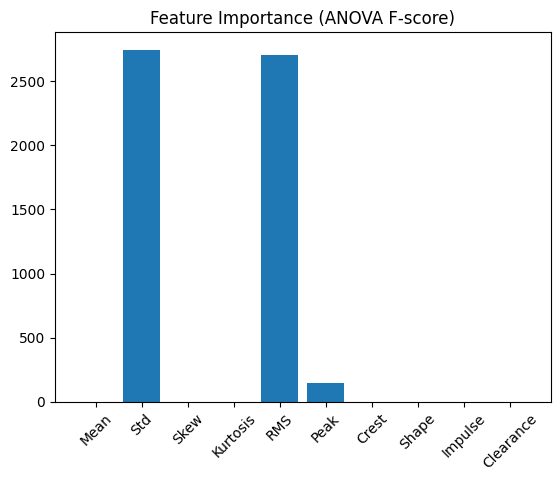

SVM Accuracy: 1.00
Naive Bayes Accuracy: 1.00
Decision Tree Accuracy: 1.00
Logistic Regression Accuracy: 1.00
KNN Accuracy: 0.96

Best model: SVM


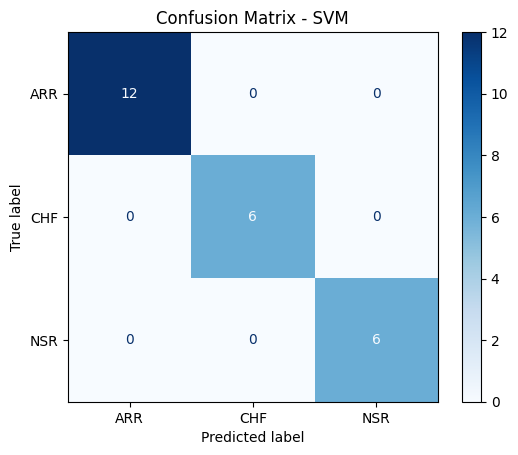

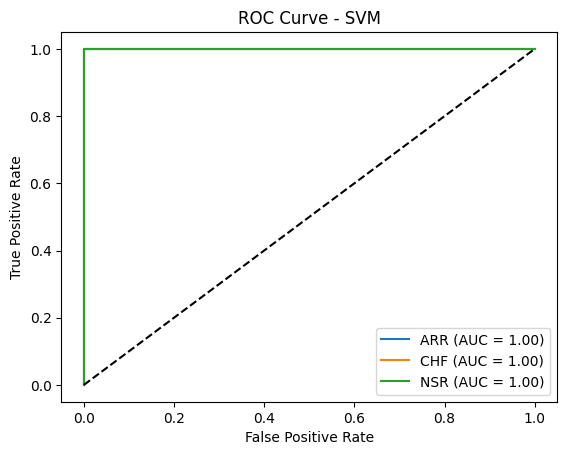

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# ---------------------------------------------------
# 1. Preprocessing utilities
# ---------------------------------------------------

def bandpass_filter(signal, fs=360, low=0.5, high=50):
    nyq = 0.5 * fs
    b, a = butter(4, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, signal)

# ---------------------------------------------------
# 2. Feature Extraction
# ---------------------------------------------------

def extract_features(x):
    mean_val = np.mean(x)
    std_val = np.std(x)
    skew_val = skew(x)
    kurt_val = kurtosis(x)
    rms_val = np.sqrt(np.mean(x**2))
    peak_val = np.max(np.abs(x))

    # Crest factor
    crest_val = peak_val / rms_val if rms_val != 0 else 0

    # Shape factor
    shape_val = rms_val / np.mean(np.abs(x)) if np.mean(np.abs(x)) != 0 else 0

    # Impulse factor
    impulse_val = peak_val / np.mean(np.abs(x)) if np.mean(np.abs(x)) != 0 else 0

    # Clearance factor
    clearance_val = peak_val / (np.mean(np.sqrt(np.abs(x)))**2) if np.mean(np.sqrt(np.abs(x))) != 0 else 0

    return [mean_val, std_val, skew_val, kurt_val, rms_val, peak_val,
            crest_val, shape_val, impulse_val, clearance_val]

# ---------------------------------------------------
# 3. Simulated ECG Dataset (replace with real dataset)
# ---------------------------------------------------

# Example: three classes (ARR, CHF, NSR)
np.random.seed(42)
signals = [np.random.randn(5000) for _ in range(50)]  # ARR
signals += [np.random.randn(5000)*0.5 for _ in range(30)]  # CHF
signals += [np.random.randn(5000)*1.5 for _ in range(40)]  # NSR
labels = (['ARR']*50) + (['CHF']*30) + (['NSR']*40)

# Preprocess + extract features
features = [extract_features(bandpass_filter(sig)) for sig in signals]
df = pd.DataFrame(features, columns=['Mean','Std','Skew','Kurtosis','RMS',
                                     'Peak','Crest','Shape','Impulse','Clearance'])
df['Label'] = labels

# ---------------------------------------------------
# 4. Feature Selection (ANOVA F-score)
# ---------------------------------------------------

X = df.drop('Label', axis=1)
y = df['Label']

f_vals, p_vals = f_classif(X, y)
plt.bar(X.columns, f_vals)
plt.xticks(rotation=45)
plt.title("Feature Importance (ANOVA F-score)")
plt.show()

# ---------------------------------------------------
# 5. Train/Test Split
# ---------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---------------------------------------------------
# 6. Train Multiple Models
# ---------------------------------------------------

models = {
    "SVM": SVC(probability=True, kernel="rbf"),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.2f}")

# ---------------------------------------------------
# 7. Best Model Evaluation
# ---------------------------------------------------

best_model = max(results, key=results.get)
print("\nBest model:", best_model)
clf = models[best_model]

# Confusion Matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_model}")
plt.show()

# ROC Curves (One-vs-Rest)
y_score = clf.predict_proba(X_test)
fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(clf.classes_):
    fpr[cls], tpr[cls], _ = roc_curve(y_test == cls, y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

for cls in clf.classes_:
    plt.plot(fpr[cls], tpr[cls], label=f"{cls} (AUC = {roc_auc[cls]:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - {best_model}")
plt.legend()
plt.show()
